In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import math

In [ ]:
# connect to google drive
in_colab = False
try:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir("/content/drive/MyDrive/Capstone/Project_1")  
    in_colab = True
except:
    pass

Mounted at /content/drive


In [ ]:
# Load Data

df = pd.read_excel("Data/Raw/Section2All_xls.xlsx", sheet_name = 'T20405-A')
# gdp_df = pd.read_excel("Data/Raw/Section1All_xls.xlsx", sheet_name = 'T10105-A') # raw annual numbers 
gdp_df = pd.read_excel("Data/Raw/Section1All_xls.xlsx", sheet_name = 'T10101-Q') # percent change quartery

### Functions to Parse Raw Data

In [ ]:
def convert_col_type(col_name):
    try:
        col_name = int(col_name)
    except:
        pass # column could be actual characters or nan

    return col_name


## Remove parentheses from column names
def remove_parentheses(label):
    return re.sub("[\(\[].*?[\)\]]", "", label)


def parse_excel_file(df):
    first_col = df.columns[0]
    top_row = df.index[df[first_col] == 'Line'].tolist()[0]

    df = df[top_row:].reset_index(drop=True) # remove headers
    df_columns = df.iloc[0].apply(convert_col_type)
    df.columns = df_columns
    df = df.drop(0).reset_index(drop=True)
    
    try:
        first_blank = df.index[df['Line'].isna()].tolist()[0]
        df = df.iloc[:first_blank]
    except:
        pass
    # # dataframe has years as columns and features as rows - transpose to opposite

    rotated_df = df.T
    column_labels = rotated_df.iloc[1]
    # # column_labels

    # ## format labels
    column_labels = [remove_parentheses(i) for i in column_labels]
    column_labels = [x.strip() for x in column_labels]
    rotated_df.columns = column_labels
    # rotated_df.head(7)

    df = rotated_df.reset_index().rename(columns={0: 'Year'}, errors='ignore')
    df = df[3:]
    
    # df['Year'] = df['Year'].astype(int)
    # vals = list(df['Year'])
    # year_rows = [i for i in range(len(vals)) if type(vals[i]) == int]
    # df = df[year_rows[0]:]

    return df 


df = parse_excel_file(df)
gdp_df = parse_excel_file(gdp_df)

In [ ]:
gdp_df.head()

,Year,Gross domestic product,Personal consumption expenditures,Goods,Durable goods,Nondurable goods,Services,Gross private domestic investment,Fixed investment,Nonresidential,...,Goods,Services,Imports,Goods,Services,Government consumption expenditures and gross investment,Federal,National defense,Nondefense,State and local
3,1947Q2,-1.1,6.8,7.4,8.7,7,5.9,-27.3,-10,-6.1,...,-10.7,38.3,7.9,9.4,3.4,-0.4,-3.3,-25.2,224.5,5.7
4,1947Q3,-0.8,1.3,2.7,5.6,1.9,-0.8,-11.3,13.6,-7.2,...,-20.4,-8.4,-38.2,-43.9,-14.8,-0.1,-5,11.2,-48.5,9.4
5,1947Q4,6.4,0.1,1.5,28.6,-5.1,-2.1,102.9,37.2,11.6,...,-41,-17.2,23.5,5.5,98,-3.2,-8.6,8.9,-58.5,6.4
6,1948Q1,6.2,2,0.6,-2,1.3,4.3,47.8,13.4,25.3,...,-15.5,-25.5,61.6,86.5,5.7,6.1,10.4,-4.5,113.2,-0.9
7,1948Q2,6.8,4.7,3.7,2.7,4,6.4,27.1,-0.6,-12.7,...,-34.6,-18.6,16.8,16.5,17.3,14.9,16.9,-8.7,200.7,11.4


In [ ]:
def scrape_cpi_data(df, quarterly_annual):

    cpi_data_html = pd.read_html('https://www.usinflationcalculator.com/inflation/consumer-price-index-and-annual-percent-changes-from-1913-to-2008/')

    cpi_data_df = cpi_data_html[0]
    cpi_columns = cpi_data_df.iloc[1]

    cpi_data_df = cpi_data_df[2:]
    cpi_data_df.columns = cpi_columns

    if quarterly_annual == 'annual':
        cpi_data_df['Year'] = cpi_data_df['Year'].astype(int)
        cpi_data_df['Avg'] = cpi_data_df['Avg'].astype(float)      

    if quarterly_annual == 'quarterly':
        cpi_data_df = calculate_quarterly_data(cpi_data_df)

    df = pd.merge(df, cpi_data_df, how='left', on='Year')

    return df


def calculate_quarterly_data(cpi_data_df):

    cpi_months = ['Jan', 'Feb', 'Mar', 
              'Apr', 'May', 'June', 
              'July', 'Aug', 'Sep',
              'Oct', 'Nov', 'Dec']

    cpi_data_df = cpi_data_df.drop(112) # drop year 2023 - only partial
    cpi_data_df[cpi_months] = cpi_data_df[cpi_months].astype(float)

    
    cpi_data_df['Q1'] = cpi_data_df[['Jan', 'Feb', 'Mar']].mean(axis=1)
    cpi_data_df['Q2'] = cpi_data_df[['Apr', 'May', 'June']].mean(axis=1)
    cpi_data_df['Q3'] = cpi_data_df[['July', 'Aug', 'Sep']].mean(axis=1)
    cpi_data_df['Q4'] = cpi_data_df[['Oct', 'Nov', 'Dec']].mean(axis=1)

    subset = cpi_data_df[['Year', 'Q1', 'Q2', 'Q3', 'Q4']]
    cpi_quarterly = subset.melt('Year').rename(columns={1: "Quarter"})
    cpi_quarterly['Year'] = cpi_quarterly['Year'].astype(str) + cpi_quarterly['Quarter']

    cpi_quarterly = cpi_quarterly.drop(columns=['Quarter'])
    cpi_quarterly = cpi_quarterly.rename(columns={"value": 'CPI'})

    return cpi_quarterly



df = scrape_cpi_data(df, 'annual')
gdp_df = scrape_cpi_data(gdp_df, 'quarterly')

In [46]:
gdp_df.head()

,Year,Gross domestic product,Personal consumption expenditures,Goods,Durable goods,Nondurable goods,Services,Gross private domestic investment,Fixed investment,Nonresidential,...,Services,Imports,Goods,Services,Government consumption expenditures and gross investment,Federal,National defense,Nondefense,State and local,CPI
0,1947Q2,-1.1,6.8,7.4,8.7,7,5.9,-27.3,-10,-6.1,...,38.3,7.9,9.4,3.4,-0.4,-3.3,-25.2,224.5,5.7,21.933333
1,1947Q3,-0.8,1.3,2.7,5.6,1.9,-0.8,-11.3,13.6,-7.2,...,-8.4,-38.2,-43.9,-14.8,-0.1,-5,11.2,-48.5,9.4,22.566667
2,1947Q4,6.4,0.1,1.5,28.6,-5.1,-2.1,102.9,37.2,11.6,...,-17.2,23.5,5.5,98,-3.2,-8.6,8.9,-58.5,6.4,23.166667
3,1948Q1,6.2,2,0.6,-2,1.3,4.3,47.8,13.4,25.3,...,-25.5,61.6,86.5,5.7,6.1,10.4,-4.5,113.2,-0.9,23.533333
4,1948Q2,6.8,4.7,3.7,2.7,4,6.4,27.1,-0.6,-12.7,...,-18.6,16.8,16.5,17.3,14.9,16.9,-8.7,200.7,11.4,23.933333


### Stationarity - An Assumption of Time Series Data

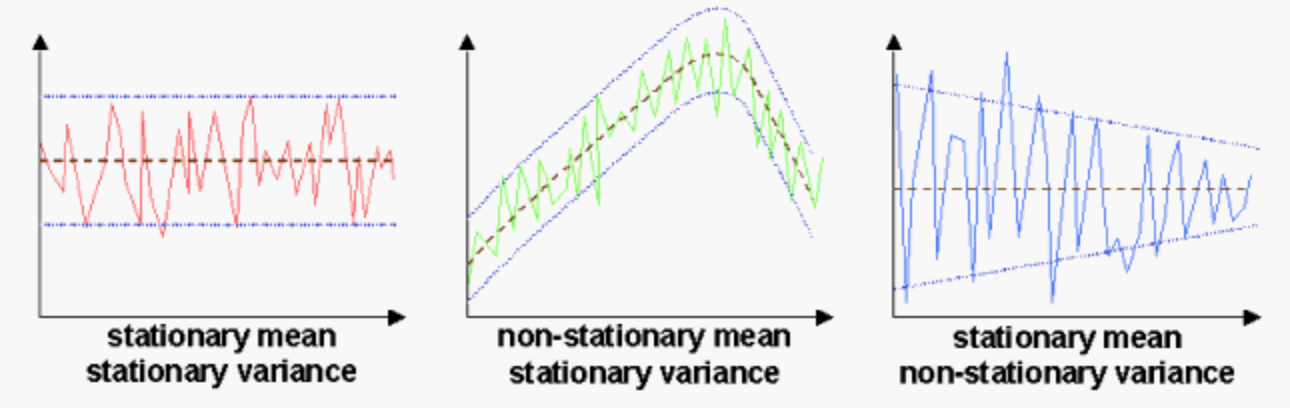

In [ ]:
from IPython.display import Image

Image(filename = "Notebooks/_Archive/image.png", width=700)

In [ ]:
def normalize(df_column_data):
    df_values = list(df_column_data)
    normalized_values = [(float(i)-np.mean(df_values))/np.std(df_values) for i in df_values]

    return normalized_values
    

def transform_data(data_list):
    transformation_dict = {}

    e_vals = [math.exp(i) for i in data_list]
    square_roots = [(i)**(1/2) for i in data_list]
    third_roots = [(i)**(1/3) for i in data_list]
    squared = [(i)**(2) for i in data_list]

    # log_cpi = [math.log(i) for i in data_list]
    return {'original': data_list,
            "e": e_vals,
            "square_roots": square_roots,
            "third_roots": third_roots,
            "squared": squared
            }

## Gross Domestic Product

In [ ]:
gdp_normalized = normalize(gdp_df['Gross domestic product'])
transformed_gdp = transform_data(gdp_normalized)

In [ ]:
def plot_distribution(dict_of_vals):
    fig, ax = plt.subplots(1, len(dict_of_vals.keys()), figsize = (20, 4))

    keys = list(dict_of_vals.keys())

    for i in range(len(dict_of_vals.keys())):

        data_to_plot = dict_of_vals[keys[i]]
        avg_of_data = sum(data_to_plot)/len(data_to_plot)
        ax[i].plot([i for i in range(len(dict_of_vals[keys[i]]))], dict_of_vals[keys[i]])
        ax[i].axhline(avg_of_data, color='red')
        ax[i].set_title(f"{keys[i]} data distribution")

    plt.show()

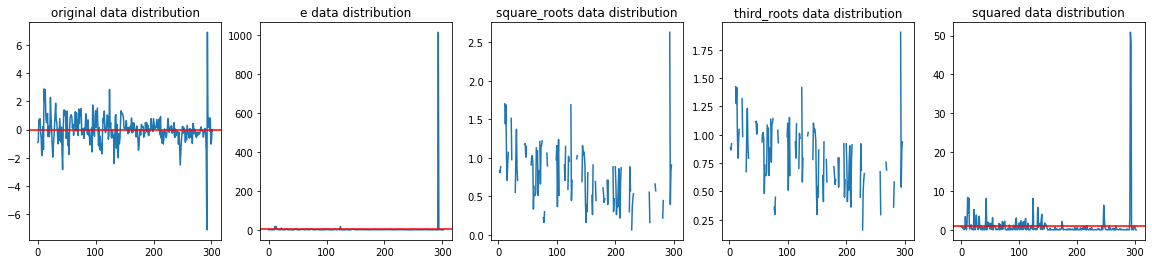

In [ ]:
# plot GDP over time

plot_distribution(transformed_gdp)

In [ ]:
quarters = list(gdp_df['Year'])
ticks = [quarters[i] for i in range(0, len(quarters), 10)]
# ticks

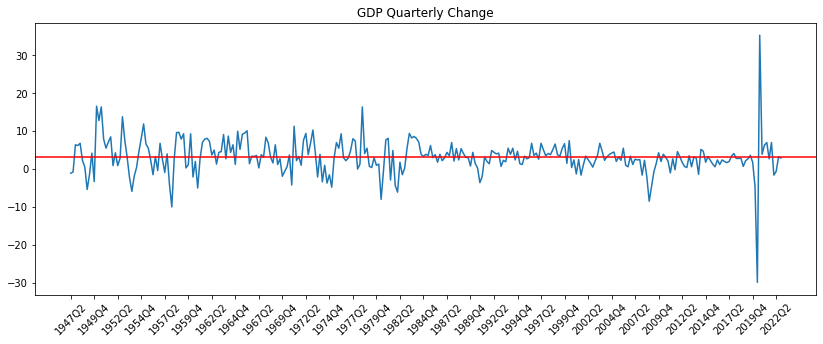

In [ ]:
plt.rcParams["figure.figsize"] = (14,5)

avg_percent_change = gdp_df['Gross domestic product'].mean()
plt.plot(gdp_df['Year'], gdp_df['Gross domestic product'])
plt.axhline(avg_percent_change, color='red')
plt.xticks(ticks, rotation=45)
plt.title("GDP Quarterly Change")
plt.show()

### Check for Seasonality

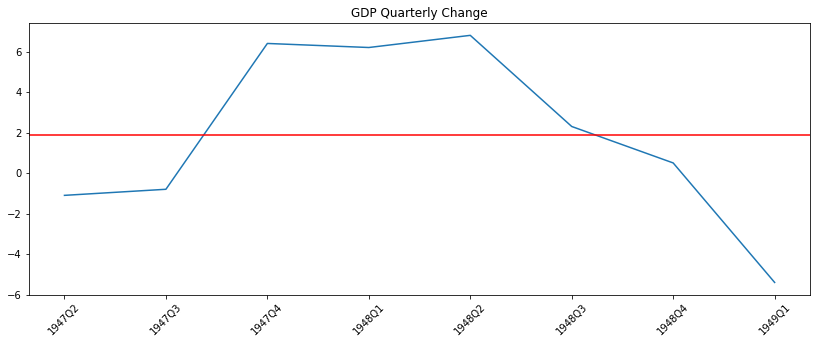

In [ ]:
# look at a subset of the data - see if any seasonal patterns exist

plt.rcParams["figure.figsize"] = (14,5)

avg_percent_change = gdp_df['Gross domestic product'].head(8).mean()
plt.plot(gdp_df['Year'].head(8), gdp_df['Gross domestic product'].head(8))
plt.axhline(avg_percent_change, color='red')
plt.xticks(rotation=45)
# plt.xticks(ticks[0:20], rotation=45)
plt.title("GDP Quarterly Change")
plt.show()

### Evaluate Correctness of Data - Does the Data Meet Stationarity Assumption?

In [ ]:
# https://machinelearningmastery.com/time-series-data-stationary-python/

from statsmodels.tsa.stattools import adfuller

result = adfuller(gdp_df['Gross domestic product'])

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')

for key, value in result[4].items():
 print('\t%s: %.3f' % (key, value))

# a significant p value indicates stationarity (what we are looking for)

ADF Statistic: -10.228533
p-value: 0.000000
Critical Values:
	1%: -3.452
	5%: -2.871
	10%: -2.572


## Consumer Price Index

In [ ]:
# cpi_normalized = normalize(df['Avg'])
# transformed_cpi = transform_data(cpi_normalized)

cpi_normalized = normalize(gdp_df['CPI'])
transformed_cpi = transform_data(cpi_normalized)

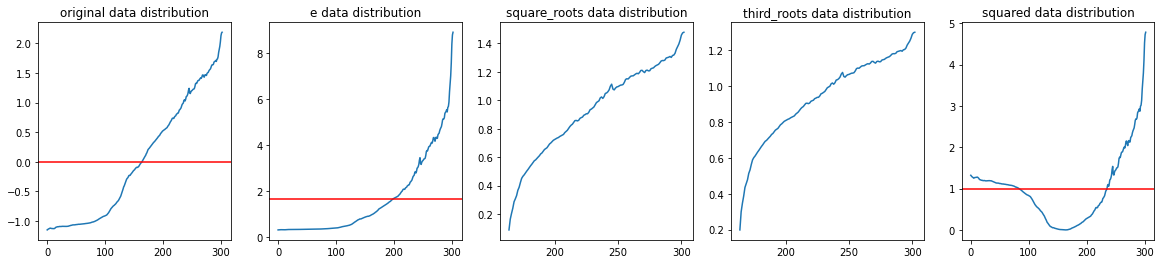

In [ ]:
# Plot CPI

plot_distribution(transformed_cpi)

In [ ]:
cpi_monthly_df = pd.read_excel("Data/CPI_Monthly_Change.xlsx")
cpi_monthly_df = cpi_monthly_df.drop('Unnamed: 0', axis = 1)

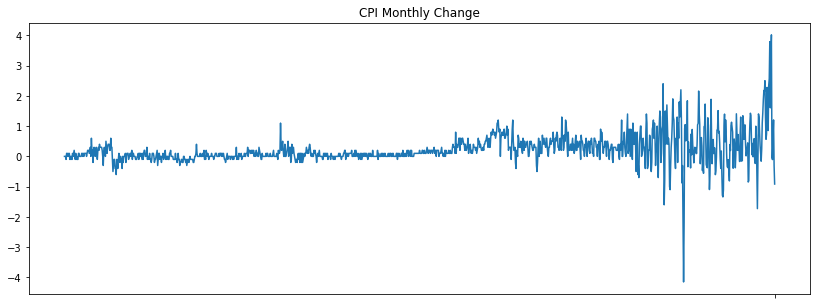

In [ ]:
plt.plot(cpi_monthly_df['TimeStamp'], cpi_monthly_df['Change'])
plt.title("CPI Monthly Change")
plt.xticks("")
plt.show()

### Check for Seasonality

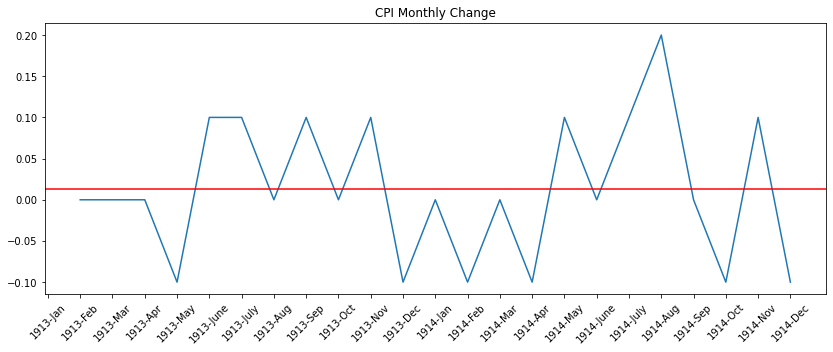

In [ ]:
plt.rcParams["figure.figsize"] = (14,5)

avg_percent_change = cpi_monthly_df['Change'].head(24).mean()
plt.plot(cpi_monthly_df['TimeStamp'].head(24), cpi_monthly_df['Change'].head(24))
plt.axhline(avg_percent_change, color='red')
plt.xticks(rotation=45)
# plt.xticks(ticks[0:20], rotation=45)
plt.title("CPI Monthly Change")
plt.show()

### There is a possibility seasonality exists in the CPI Data - will need to do further tests

In [ ]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(cpi_monthly_df['Change'].drop(0))

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')

for key, value in result[4].items():
 print('\t%s: %.3f' % (key, value))

# a significant p value indicates stationarity (what we are looking for)

ADF Statistic: -1.676679
p-value: 0.443166
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568


### Necessary to continue evaluating data transformations / alternate analysis for Consumer Price Index Data

## Old Code

In [ ]:
# smaller_roots = [(i)**(1/1.5) for i in cpi_vals]
# normalized_cpi_vals = [(float(i)-np.mean(smaller_roots))/np.std(smaller_roots) for i in smaller_roots]

In [ ]:
# normalized_cpi_vals = [(float(i)-np.mean(cpi_vals))/np.std(cpi_vals) for i in cpi_vals]
# e_cpi_vals = [math.exp(i) for i in normalized_cpi_vals]
# smaller_roots = [(i)**(1/1.5) for i in normalized_cpi_vals]
# square_roots = [(i)**(1/2) for i in normalized_cpi_vals]
# third_roots = [(i)**(1/3) for i in normalized_cpi_vals]
# # log_cpi = [math.log(i) for i in normalized_cpi_vals]
# squared = [(i)**(2) for i in normalized_cpi_vals]
# # third_roots
# # norm

In [ ]:
# df['Normalized_CPI'] = normalized_cpi_vals
# df['e_CPI'] = e_cpi_vals
# df['Smaller_Roots_CPI'] = smaller_roots
# df['Squared_CPI'] = squared
# df['Square_Roots_CPI'] = square_roots
# # df['Third_Roots_CPI'] = third_roots

In [ ]:
# df['Shifted'] = df['Normalized_CPI'].shift(1)

In [ ]:
# df[['Square_Roots_CPI', 'Shifted']]

In [ ]:
# df['Change'] = df['Normalized_CPI'] - df['Shifted']
# df['Change']

In [ ]:
# df['Change'].plot()

In [ ]:
# test = pd.read_excel("Data/CPI_Monthly.xlsx")
# test

In [ ]:
# months = ['Jan', 'Feb']

# test.melt(['Year', 'Jan', 'Feb'])